### Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the dependencies for preprocessing of images 

In [ ]:
import numpy as np 
import pandas as pd 
from plotly.offline import init_notebook_mode, iplot
import os
from os import listdir
import plotly.graph_objs as go
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle                  


### Loading of Image Dataset

In [ ]:
image_dir='/content/drive/MyDrive/Brain tumor prediction/image dataset'


### Making the directory for augmented images

**A directory is formed by using os.makedirs() function for augmented images.**

In [ ]:
os.makedirs('/content/drive/MyDrive/Brain tumor prediction/augmented images', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Brain tumor prediction/augmented images/yes', exist_ok = True)
os.makedirs('/content/drive/MyDrive/Brain tumor prediction/augmented images/no', exist_ok = True)

augmented_data_path ='/content/drive/MyDrive/Brain tumor prediction/augmented images'

augmented_yes =augmented_data_path+'/yes'
augmented_no = augmented_data_path+'/no'
IMG_SIZE = (256,256)


## Augmentation of images 
**About the data:
The dataset contains 2 folders: (yes) and (no). The yes folder contains 155 Brain MRI Images that are tumorous and no folder contains 98 Brain MRI Images that are non-tumorous.**

**Since, dataset is not sufficient for training purpose, so we have used image augmentation.**

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):

    # imageDataGenerator provides different augmentation techniques like standardization, rotation, shifts, flips, brightness to augment the images
    data_gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, 
                                  brightness_range=(0.3, 1.0), horizontal_flip=True, vertical_flip=True, fill_mode='nearest' )


    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break


In [ ]:

dir = os.listdir(augmented_yes) 

if len(dir) == 0: 
    augment_data(file_dir=image_dir+'/yes',n_generated_samples=6, save_to_dir=augmented_yes)
    augment_data(file_dir=image_dir+'/no', n_generated_samples=9, save_to_dir=augmented_no)

else:
    print(len(dir))

print("augmented images having tumor:- ", len(dir))
dir_no = os.listdir(augmented_no) 
print("augmented images not having tumor:- ", len(dir_no))


1085
augmented images having tumor:-  1085
augmented images not having tumor:-  980


In [ ]:
def load_data(dir_list):

    X = []
    y = []

    #  image_width, image_height = image_size
    
    for directory in dir_list:                               # taking augmented-image directory at a time
        for filename in listdir(directory):                  # take the images which are in the dir
            image = cv2.imread(directory+'/'+filename)       # concatenate the image name with the path of directory and read the image one by one

            # append the image to X array
            X.append(image)

            # append a value 1 to the target array y if the image is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    
    # convert image to numpy array        
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples:- {len(X)}')
    print(f'X shape is:- {X.shape}')
    print(f'y shape is:- {y.shape}')
    
    return X, y


In [ ]:
def plot_samples(X, y, labels_dict, n):

    # np.argwhere() is used to find the indices of non-zero elements
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)                     # i = 30/10 = 3

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)           # (3,10,1)  means 3 rows, 10 columns and c=1 indicates 1st image then value of c will be increased by 1
            plt.imshow(img[0])           # to show the image

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


In [ ]:
X_train, y_train = load_data([augmented_yes, augmented_no])


Number of examples:- 2065
X shape is:- (2065,)
y shape is:- (2065, 1)


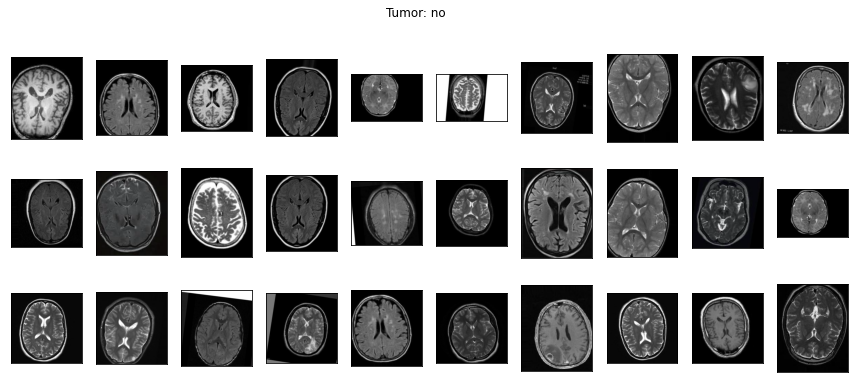

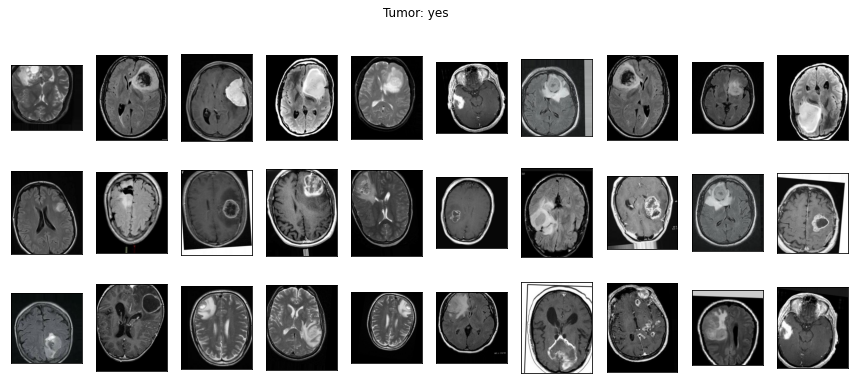

In [ ]:
plot_samples(X_train, y_train, ['no','yes'], 30)


## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.[How to find extreme points in OpenCv?](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

## After applying the cropping function

In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # bilateral filter is used for smoothening the images by reducing the noise and preserve its edges 
    gray = cv2.bilateralFilter(gray, 9, 75, 75) 


    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]     # cv.threshold is used to apply the thresholding
    thresh = cv2.erode(thresh, None, iterations=2)                  # used to decrease the small regions of noise in the image.
    thresh = cv2.dilate(thresh, None, iterations=2)                 # used to increase the object area which is decreased by erode method


    # contours stores the (x,y) coordinates of the boundary of a shape with same intensity
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


In [ ]:
img = cv2.imread('/content/drive/My Drive/Brain tumor prediction/image dataset/yes/Y7.jpg')
img = cv2.resize( img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC )

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.bilateralFilter(gray, 9, 75, 75) 

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest contour
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# draw contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points 
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1) 
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


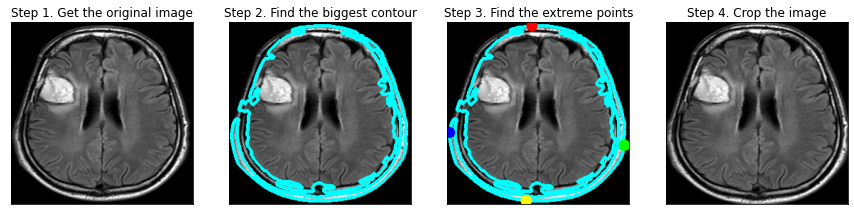

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [ ]:
def Croping_Data(train):

    X = []   
    for img in train:
        image = crop_brain_contour(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    return X


In [ ]:
X = Croping_Data(X_train)


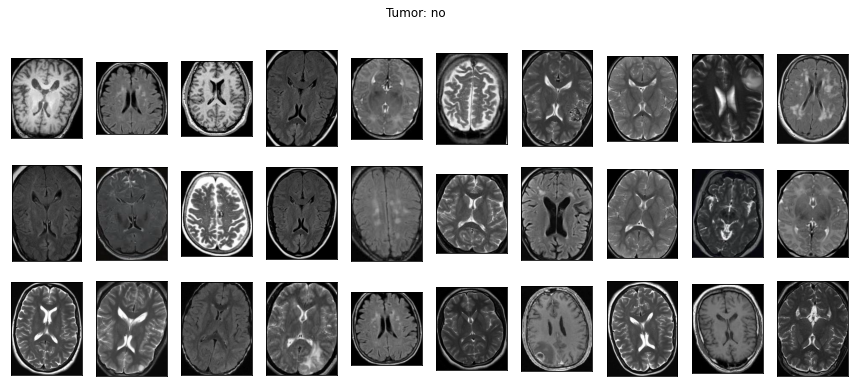

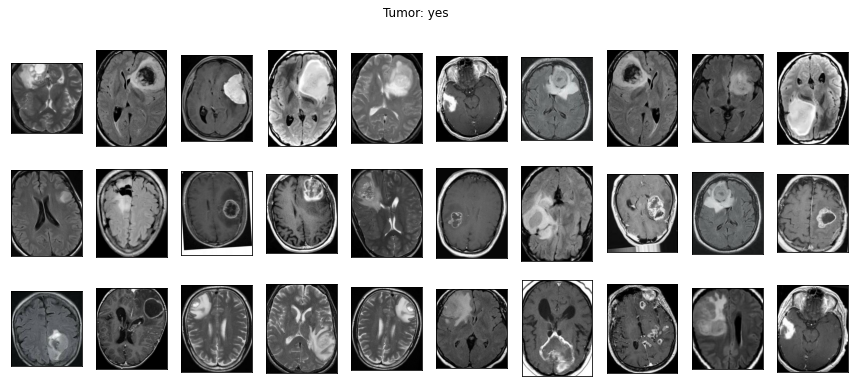

In [ ]:
plot_samples(X, y_train, ['no','yes'], 30)


In [ ]:
def Resize_Data(train):

    X = []
    IMG_WIDTH, IMG_HEIGHT = (256, 256)
        
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        
        image = image / 255
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    return X


In [ ]:

# IMG_WIDTH, IMG_HEIGHT = (256, 256)

X = Resize_Data(X)
y = y_train


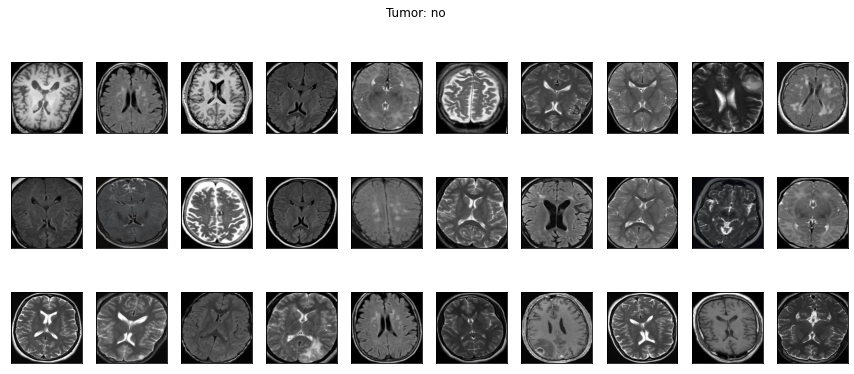

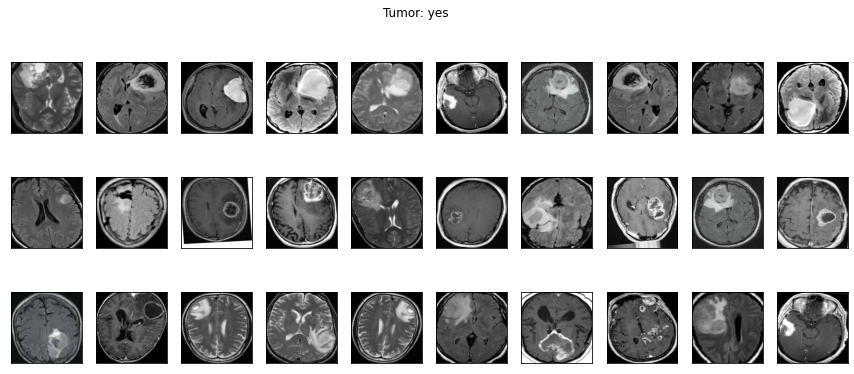

In [ ]:
plot_samples(X, y_train, ['no','yes'],30)


## Visualization of data

In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)


In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))


number of training examples = 1652
number of validation examples = 207
number of test examples = 206


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)                              # iplot is interactive plot


In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    
    model = Model(inputs = X_input, outputs = X)
    
    return model


In [ ]:
IMG_WIDTH, IMG_HEIGHT = (256, 256)

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 254, 254, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 32)      50208     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 248, 248, 32)     

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))


Epoch 1/30
52/52 [==============================] - 11s 221ms/step - loss: 3.2623 - accuracy: 0.5878 - val_loss: 1.2644 - val_accuracy: 0.6135
Epoch 2/30
52/52 [==============================] - 11s 204ms/step - loss: 0.8751 - accuracy: 0.7542 - val_loss: 1.2852 - val_accuracy: 0.6280
Epoch 3/30
52/52 [==============================] - 11s 205ms/step - loss: 0.6555 - accuracy: 0.7887 - val_loss: 0.6432 - val_accuracy: 0.7633
Epoch 4/30
52/52 [==============================] - 11s 204ms/step - loss: 1.0565 - accuracy: 0.7621 - val_loss: 2.0002 - val_accuracy: 0.6184
Epoch 5/30
52/52 [==============================] - 11s 204ms/step - loss: 0.5646 - accuracy: 0.8596 - val_loss: 0.4632 - val_accuracy: 0.8454
Epoch 6/30
52/52 [==============================] - 11s 204ms/step - loss: 0.3940 - accuracy: 0.8904 - val_loss: 4.0945 - val_accuracy: 0.5411
Epoch 7/30
52/52 [==============================] - 11s 204ms/step - loss: 0.9367 - accuracy: 0.8057 - val_loss: 2.2655 - val_accuracy: 0.6812

In [ ]:
history = model.history.history

### Plotting of accuracy

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # training loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # training accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

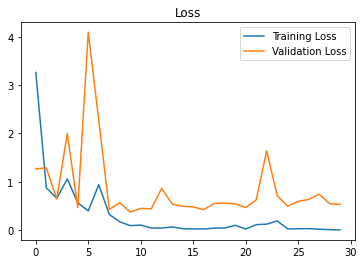

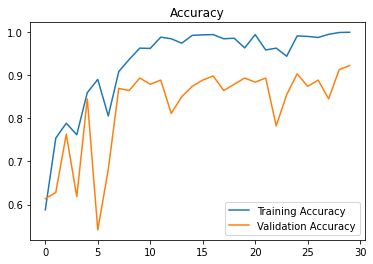

In [ ]:
plot_metrics(history)

In [ ]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
  

Val Accuracy = 0.92


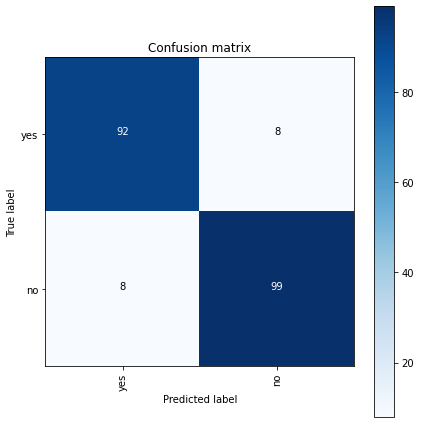

In [ ]:
labels = ['yes','no']
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)


Val Accuracy = 0.90


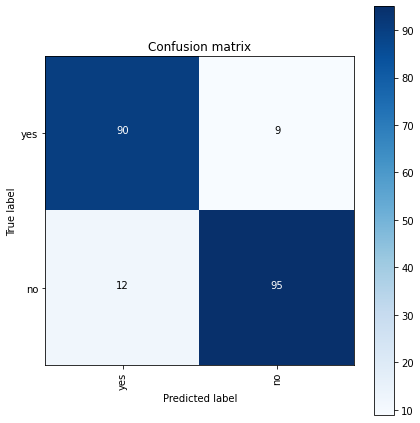

In [ ]:
# validate on val set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

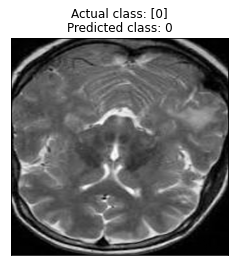

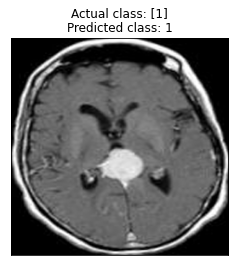

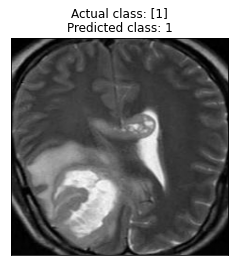

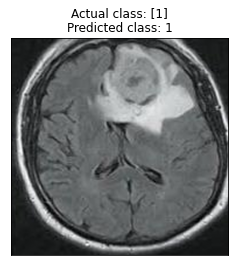

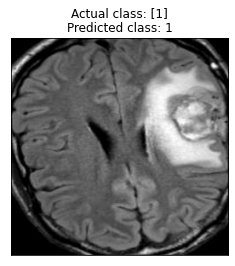

In [ ]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()
